# Inizialization


In [ ]:
from IPython.display import clear_output 
from google.colab import drive
drive.mount('/content/drive')
drive_path = 'drive/My Drive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import transforms as T
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Dataset

## Training dataset


In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import xml.etree.ElementTree as ET


class Take_training_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images_giusti"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images_giusti", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(os.path.join(drive_path, 'frames_giusti', 'frame_'+str(idx).zfill(6)+'.xml'))
        root = tree.getroot()
        boxes = []
        label=[]
        area=0;
        for objects in root.findall('object'):
          for objects1 in objects.findall('bndbox'):
            xmin = float(objects1.find('xmin').text)
            ymin = float(objects1.find('ymin').text)
            xmax = float(objects1.find('xmax').text)
            ymax = float(objects1.find('ymax').text)
          can_type = objects.find('name').text
          if(can_type == 'beer'):
            can_type = 1
          else:
            can_type = 2
          boxes.append([xmin, ymin, xmax, ymax])
          label.append(can_type)
        if boxes:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.as_tensor(label, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros(len(label), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)


## Data Augmentation

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import imageio
import xml.etree.ElementTree as ET
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

class Augment_raining_image(torch.utils.data.Dataset):
    def __init__(self, root, augmentation, image_save_folder=None, xml_save_folder=None):
        self.root = root
        self.augmentation = augmentation
        self.image_save_folder = image_save_folder
        self.xml_save_folder = xml_save_folder
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, train_image_folder))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, train_image_folder, self.imgs[idx])
        img = imageio.imread(img_path)
        tree = ET.parse(os.path.join(drive_path, train_frame_folder, 'frame_'+str(idx).zfill(6)+'.xml'))
        root = tree.getroot()
        boxes_list = []
        bbs_list=[]
        target = BoundingBoxesOnImage([], shape=img.shape)
        for objects in root.findall('object'):
          for objects1 in objects.findall('bndbox'):
            xmin = float(objects1.find('xmin').text)
            ymin = float(objects1.find('ymin').text)
            xmax = float(objects1.find('xmax').text)
            ymax = float(objects1.find('ymax').text)
          bbs_list.append(BoundingBox(x1=xmin, y1=ymin, x2=xmax, y2=ymax))
          boxes_list.append([xmin, ymin, xmax, ymax])
        if boxes_list:
          bbs = BoundingBoxesOnImage(bbs_list, shape=img.shape)
          img, target = self.augmentation(image=img, bounding_boxes=bbs)
          if self.xml_save_folder is not None:
            objects = root.findall('object')
            for i, obj in enumerate(objects):
              for bb in obj.findall('bndbox'):
                bb.find('xmin').text = str(target.bounding_boxes[i].x1)
                bb.find('ymin').text = str(target.bounding_boxes[i].y1)
                bb.find('xmax').text = str(target.bounding_boxes[i].x2)
                bb.find('ymax').text = str(target.bounding_boxes[i].y2)
        if self.image_save_folder is not None:
          new_img_path = os.path.join(self.root, self.image_save_folder, self.imgs[idx])
          imageio.imwrite(new_img_path, img)
        if self.xml_save_folder is not None:
          new_xml_path = os.path.join(drive_path, self.xml_save_folder, 'frame_'+str(idx).zfill(6)+'.xml')
          tree.write(new_xml_path)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [ ]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt  

aug_image_save_folder = None # 'images_aug'
aug_xml_save_folder = None # 'frames_aug'
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # horizontal flips
    # iaa.Crop(percent=(0, 0.1)), # random crops

    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),

    # Add gaussian noise.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),

    # Make some images brighter and some darker.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),

    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    ### in our case we should not have a too large rotate angel otherwise the bounding box will be no longer compact
    iaa.Affine(
        rotate=(-15, 15),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order
seq_empty = iaa.Sequential()


pic_aug = Augment_raining_image(drive_path, augmentation=seq, image_save_folder=aug_image_save_folder, xml_save_folder=aug_xml_save_folder)
pic = Augment_raining_image(drive_path, augmentation=seq_empty)

# #### testing augmentation on random images in training set ####
# for i in range(2):
#     num=random.randint(0,len(pic_aug)-1)
#     img_aug, bbs_aug = pic_aug[num]
#     img, bbs = pic[num]
#     # image with BBs before/after augmentation (shown below)
#     image_before = bbs.draw_on_image(img, size=2, color=[255, 0, 0])
#     image_after = bbs_aug.draw_on_image(img_aug, size=2, color=[0, 255, 255])
#     ia.imshow(image_before)
#     ia.imshow(image_after)

# #### testing augmentation on a specific image in training set ####
# num=483
# img, bbs = pic[num]
# image_before = bbs.draw_on_image(img, size=2, color=[255, 0, 0])
# ia.imshow(image_before)
# for i in range(10):
#     img_aug, bbs_aug = pic_aug[num]
#     # image with BBs before/after augmentation (shown below)
#     image_after = bbs_aug.draw_on_image(img_aug, size=2, color=[0, 255, 255])
#     ia.imshow(image_after)

NameError: ignored

### Generate New Data

In [ ]:
aug_image_save_folder = 'images_aug_1' # 'images_aug_0', 'images_aug_1'... or None
aug_xml_save_folder = 'frames_aug_1' # 'frames_aug_0', 'frames_aug_1'... or None

pic_aug = Augment_raining_image(drive_path, augmentation=seq, image_save_folder=aug_image_save_folder, xml_save_folder=aug_xml_save_folder)

img_amt = len(Take_training_image(drive_path, get_transform(train=False)))
cnt = 0
for idx in range(img_amt):
    img_aug, bbs_aug = pic_aug[idx]
    if (idx / img_amt * 100) > cnt:
        print("Augmenting data...{}%".format(cnt))
        cnt += 20
print("Finished. New images and .xml files are saved in folder {} and {}".format(aug_image_save_folder, aug_xml_save_folder))

NameError: ignored

## Testing dataset

In [ ]:
import os
import numpy as np
import torch
from PIL import Image

class Take_test_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images_test1"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images_test1", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target={}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
        
    def __len__(self):
        return len(self.imgs)

## All images dataset

In [ ]:
import os
import numpy as np
import torch
from PIL import Image

class Take_all_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target={}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
        
    def __len__(self):
        return len(self.imgs)

# Model

## Default model

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

## New model definition

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((64,128,256),),
                                   aspect_ratios=((0.5, 1.0, 1.5),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=3,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                   min_size=300,
                   max_size=500)

## Downloading a model

In [ ]:
available_net=os.listdir(os.path.join(drive_path,"models"))
print("Available nets:", available_net)
print("Write the name of the net that you want to download:")
name_net = input()
PATH=os.path.join(drive_path,"models",name_net+".pt")
model.load_state_dict(torch.load(PATH))

Available nets: ['yolo_model.pt', 'dnn_1.pt', 'dnn_2.pt', 'dnn_test.pt', 'dnn_3.pt', 'model_param.ipynb', 'samu_net_test1.pt', 'working_net.pt', 'working_net2.pt']
Write the name of the net that you want to download:
yolo_model


RuntimeError: ignored

## Uploading model

In [ ]:
name_net = input('Insert the name of the net: ')
PATH=os.path.join(drive_path,"models",name_net+".pt")
torch.save(model.state_dict(), PATH)

Insert the name of the net: working_net2


## Training model

In [ ]:
dataset = Take_training_image(drive_path, get_transform(train=True))
dataset_test = Take_training_image(drive_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

# # when we apply the augmented data to training, we iterate them both by catenate the two dataloaders in cat_dataloaders()
# dataset_aug = Take_training_image(os.path.join(drive_path, 'images_aug_0'),os.path.join(drive_path, 'frames_aug_0'), get_transform(train=False))
# dataset = torch.utils.data.ConcatDataset([dataset_orig,dataset_aug])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

from torch.optim.lr_scheduler import StepLR
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/705]  eta: 1:56:37  lr: 0.000012  loss: 0.0814 (0.0814)  loss_classifier: 0.0158 (0.0158)  loss_box_reg: 0.0641 (0.0641)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 9.9252  data: 8.1786  max mem: 2119
Epoch: [0]  [ 10/705]  eta: 0:25:17  lr: 0.000083  loss: 0.0463 (0.0454)  loss_classifier: 0.0123 (0.0126)  loss_box_reg: 0.0367 (0.0321)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 2.1840  data: 0.7525  max mem: 2387
Epoch: [0]  [ 20/705]  eta: 0:20:46  lr: 0.000154  loss: 0.0463 (0.0476)  loss_classifier: 0.0123 (0.0134)  loss_box_reg: 0.0287 (0.0335)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0004 (0.0006)  time: 1.4139  data: 0.0099  max mem: 2387
Epoch: [0]  [ 30/705]  eta: 0:19:03  lr: 0.000225  loss: 0.0487 (0.0523)  loss_classifier: 0.0126 (0.0154)  loss_box_reg: 0.0300 (0.0360)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.4239  data: 0.0099  max mem: 2387


## Print an image

tensor([0.9981, 0.9968, 0.9964], device='cuda:0')
0.4208502769470215


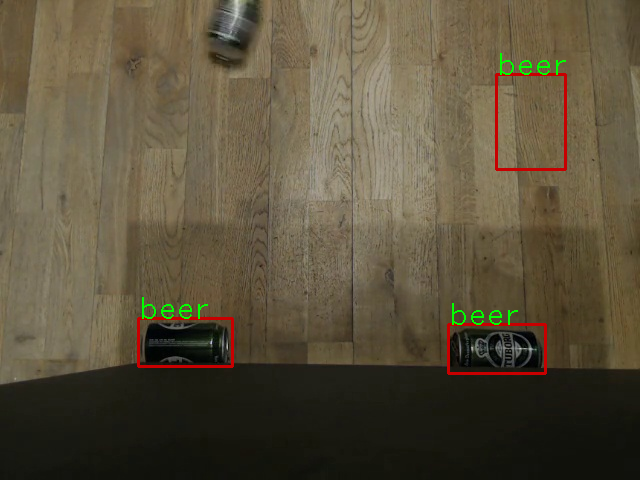

In [ ]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import random

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
picture = Take_test_image(drive_path, get_transform(train=False))
num=random.randint(0,len(picture)-1)
img, _ = picture[num]
tic = time.perf_counter()
torch.cuda.synchronize()
t0 = time.time()
# put the model in evaluation mode
model.to(device)
model.eval()
model
with torch.no_grad():
    prediction = model([img.to(device)])
box = prediction[0].get("boxes")
scores=prediction[0].get("scores")
print(scores)
labels=(prediction[0].get("labels"))
toc = time.perf_counter()
torch.cuda.synchronize()
elapsed_fp = time.time()-t0
print(elapsed_fp)
path=os.path.join(drive_path, 'images_test1', 'frame_'+str(num).zfill(6)+'.jpg')
image = cv2.imread(path)

for i in range(len(scores)):
  if float(scores[i])>0.95:
    x_m=int(box[i,0].item())
    y_m=int(box[i,1].item())
    x_M=int(box[i,2].item())
    y_M=int(box[i,3].item())
    pt1 = (x_m,y_m)
    pt2 = (x_M,y_M)
    start_point = (x_m,y_m)      
    end_point = (x_M,y_M)
    color = (0, 0, 200)
    thickness = 2
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    if(int(labels[i])==1):
      image = cv2.putText(image, "beer", start_point, 2, 1,(0,255,0), 1);
    if(int(labels[i])==2):
      image = cv2.putText(image, "cola", start_point, 2, 1, (0,255,0), 1);
cv2_imshow(image)

## Render a video from test set

In [ ]:
 # pick one image from the test set
%matplotlib qt 
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

thres = 0.85
render_fps = 10
picture = Take_test_image(drive_path, get_transform(train=False))
img, _ = picture[num]
channel, height, width,  = img.shape
size = (width,height)
print(size)
forward_time = 0.
out = cv2.VideoWriter('demo_{}frames_{}fps_thres{}_{}.mp4'.format(len(picture),render_fps, thres, time.asctime( time.localtime(time.time()))),cv2.VideoWriter_fourcc(*'MP4V'), render_fps, size)

for num in range(len(picture)):
  picture = Take_test_image(drive_path, get_transform(train=False))
  img, _ = picture[num]
  tic = time.perf_counter()
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
  box = prediction[0].get("boxes")
  scores = prediction[0].get("scores")
  # print(scores)
  labels = (prediction[0].get("labels"))
  toc = time.perf_counter()
  forward_time += toc-tic
  # print(toc-tic)

  path=os.path.join(drive_path,test_image_folder, 'frame_'+str(num).zfill(6)+'.jpg')
  image = cv2.imread(path)
  # print the frame number on each frame
  image = cv2.putText(image, str(num), (20, 450), 2, 0.5, (150,150,150), 1)
  for i in range(len(scores)):
    
    if float(scores[i])>thres:
      x_m=int(box[i,0].item())
      y_m=int(box[i,1].item())
      x_M=int(box[i,2].item())
      y_M=int(box[i,3].item())
      # print(box[i])

      start_point = (x_m,y_m)

      text_point = (x_m,y_m) if y_m > 30 else (x_m,y_M+20)
      # print(start_point)
      # Ending coordinate, here (125, 80)
      # represents the bottom right corner of rectangle
      end_point = (x_M,y_M)
        
      # Black color in BGR
      color = (0, 0, 200)
        
      # Line thickness of -1 px
      # Thickness of -1 will fill the entire shape
      thickness = 2
        
      # Using cv2.rectangle() method
      # Draw a rectangle of black color of thickness -1 px
      image = cv2.rectangle(image, start_point, end_point, color, thickness)
      if(int(labels[i])==1):
        image = cv2.putText(image, "beer_{:.2f}".format(scores[i]), text_point, 2, 1,(0,255,0), 1)
      if(int(labels[i])==2):
        image = cv2.putText(image, "cola_{:.2f}".format(scores[i]), text_point, 2, 1, (0,255,0), 1)
  # cv2.imshow('frame_'+str(num).zfill(6), image)
  out.write(image)
  if num%100 == 0:
      print("Processing...Frame {} out of {}.".format(num, len(picture)))
  if cv2.waitKey(10) == ord('q'):
      break
avg_fps = len(picture)/forward_time
print("Done. total processing time: {:.2f}; average time per frame: {:.2f} sec; avg fps: {:.2f}".format(forward_time, 1/avg_fps, avg_fps))
out.release()
cv2.destroyAllWindows()

## Testing model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
picture = Take_test_image(drive_path, get_transform(train=False))
model.eval()
count=0;
num_images=len(list(sorted(os.listdir(os.path.join(drive_path,"images_test1")))));
for i in range(num_images):
  img, _ = picture[i]
  tree = ET.parse(os.path.join(drive_path,"frames_test1", 'frame_'+str(i).zfill(6)+'.xml'))
  root = tree.getroot()
  label_true=[]
  area=0;
  for objects in root.findall('object'):
    for objects1 in objects.findall('bndbox'):
      can_type = objects.find('name').text
      if(can_type == 'beer'):
        can_type = 1
      else:
        can_type = 2
      label_true.append(can_type)
  with torch.no_grad():
      prediction = model([img.to(device)])

  scores=prediction[0].get("scores")
  labels=(prediction[0].get("labels"))
  #print(scores)
  #print(box)
  #print(elapsed_fp)
  scores=list(scores)
  labels=list(labels)
  m=0;
  for j in range(len(scores)):
    if float(scores[j-m])<0.9:
      del scores[j-m]
      del labels[j-m]
      #print(scores)
      m+=1
  labels.sort()
  label_true.sort()
  if labels == label_true:
    count=count+1
print("The network correctly classified  "+str(count/num_images)+"  of the photos")

The network correctly classified  0.3444730077120823  of the photos


# Object tracking

In [ ]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

class CentroidTracker():
	def __init__(self, maxDisappeared=5):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()

		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
		self.maxDisappeared = maxDisappeared

	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			# return early as there are no centroids or tracking info
			# to update
			return self.objects

		# initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		# loop over the bounding box rectangles
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			# use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

		# if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])

		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value as at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()

			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()

			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue

				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0

				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)

			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		# return the set of trackable objects
		return self.objects

In [ ]:
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow



class Take_test_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images_test1"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images_test1", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target={}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

img_array = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

ct_beer = CentroidTracker()
ct_coke = CentroidTracker()
picture = Take_test_image(drive_path, get_transform(train=False))
num_images=len(picture)
model.to(device)
model.eval()
global_label=[]
for i in range(num_images):

  path=os.path.join(drive_path, 'images_test1', 'frame_'+str(i).zfill(6)+'.jpg')
  frame = cv2.imread(path)

  img, _ = picture[i]

  with torch.no_grad():
    detection = model([img.to(device)])

  box1 = detection[0].get("boxes")
  scores = detection[0].get("scores")
  labels=detection[0].get("labels")
  labels=list(labels)
  scores=list(scores)
  labels1=labels
  box1=list(box1)
  rects_beer=[]
  rects_coke=[]
  m=0
  centerx=[]
	# loop over the detections
  for j in range(len(scores)):
    # filter out weak detections by ensuring the predicted
    # probability is greater than a minimum threshold
    if scores[j] > 0.9:
      # compute the (x, y)-coordinates of the bounding box for
			# the object, then update the bounding box rectangles list
      
      box = np.array(box1[j].cpu())      
			# draw a bounding box surrounding the object so we can
			# visualize it
      (startX, startY, endX, endY) = box.astype("int")
      if labels[j]==1:
        rects_beer.append(box.astype("int"))
        cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 255, 0), 2)
      if labels[j]==2:
        rects_coke.append(box.astype("int"))
        cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 0, 255), 2)
	# update our centroid tracker using the computed set of bounding
	# box rectangles
  objects_beer = ct_beer.update(rects_beer)
  objects_coke = ct_coke.update(rects_coke)
	# loop over the tracked objects
  for (objectID, centroid) in objects_beer.items():    
   	# draw both the ID of the object and the centroid of the
		# object on the output frame
    text = "Beer {}".format(objectID)
    cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
  for (objectID, centroid) in objects_coke.items():    
   	# draw both the ID of the object and the centroid of the
		# object on the output frame
    text = "Coke {}".format(objectID)
    cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 0, 255), -1)




	# show the output frame
  #clear_output()
  #cv2_imshow(frame)
  key = cv2.waitKey(1) & 0xFF
  img_array.append(frame)

	# if the `q` key was pressed, break from the loop
  if key == ord("q"):
   break
height, width, layers = frame.shape
size = (width,height)
out = cv2.VideoWriter(os.path.join(drive_path, 'videos', 'video_traking2.avi'),cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
print(objectID)
global_label

4


[tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(2, device='cuda:0')]

In [ ]:
global_label
num=global_label[0:10].count(2)
print(num)
global_label

2


[tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(2, device='cuda:0')]

# Yolo


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%%shell
git clone https://github.com/ultralytics/yolov5
pip install -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

class CentroidTracker():
	def __init__(self, maxDisappeared=5):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()

		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
		self.maxDisappeared = maxDisappeared

	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			# return early as there are no centroids or tracking info
			# to update
			return self.objects

		# initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		# loop over the bounding box rectangles
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			# use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

		# if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])

		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value as at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()

			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()

			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue

				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0

				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)

			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		# return the set of trackable objects
		return self.objects

In [ ]:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 15 --data coco128.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

python3: can't open file 'train.py': [Errno 2] No such file or directory


In [ ]:
import sys
sys.path.append('/content/yolov5') # Allow us to import shared custom 


In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
from utils.datasets import exif_transpose, letterbox

ModuleNotFoundError: ignored

In [ ]:
import torch

# Model
# model = torch.hub.load('/content/yolov5', 'custom', path='/content/drive/MyDrive/models/yolo_model2.pt', source='local')
path='/content/drive/MyDrive/models/yolo_model2.pt'

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', classes=2)
model.load_state_dict(torch.load(path)['model'].state_dict())

# Images
dir = '/content/drive/MyDrive/yolo/images/test/frame_001599.jpg'
imgs = [dir]  # batch of images

# Inference
results = model(imgs)
# or .show(), .save()

print(results.xyxy)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


ModuleNotFoundError: ignored

In [ ]:
pip uninstall utils

Found existing installation: utils 1.0.1
Uninstalling utils-1.0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/tests/*
    /usr/local/lib/python3.7/dist-packages/utils-1.0.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/utils/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/tests/cindex/__init__.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_access_specifiers.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_cdb.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_code_completion.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_comment.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_cursor.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_cursor_kind.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_diagnostics.py
    /usr/local/lib/python3.7/dist-packages/tests/cindex/test_exception_specification_kind.py
    /usr/local/l

In [ ]:
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow


class Take_test_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images_test1"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images_test1", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target={}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
        
    def __len__(self):
        return len(self.imgs)


img_array = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

ct_beer = CentroidTracker()
ct_coke = CentroidTracker()
picture = Take_test_image(drive_path, get_transform(train=False))
num_images=len(picture)
model.to(device)
model.eval()
global_label=[]
for i in range(num_images):

  path=os.path.join(drive_path, 'images_test1', 'frame_'+str(i).zfill(6)+'.jpg')
  frame = cv2.imread(path)
  tic = time.perf_counter()
  torch.cuda.synchronize()
  detection = model(path)
  detection=detection.xyxy
  #print(detection)

  box1=detection[0][:,0:4]
 # print(box1)
  scores = detection[0][:,4]
 # print(scores)
  labels=detection[0][:,5]
 # print(labels)
  labels=list(labels)
  scores=list(scores)
  labels1=labels
  box1=list(box1)
  rects_beer=[]
  rects_coke=[]
  m=0
  centerx=[]
	# loop over the detections
  for j in range(len(scores)):
    # filter out weak detections by ensuring the predicted
    # probability is greater than a minimum threshold
    if scores[j] > 0.5:
      # compute the (x, y)-coordinates of the bounding box for
			# the object, then update the bounding box rectangles list
      
      box = np.array(box1[j].cpu())     
			# draw a bounding box surrounding the object so we can
			# visualize it
      (startX, startY, endX, endY) = box.astype("int")
      if labels[j]==0:
        rects_beer.append(box.astype("int"))
        cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 255, 0), 2)
      if labels[j]==1:
        rects_coke.append(box.astype("int"))
        cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 0, 255), 2)
	# update our centroid tracker using the computed set of bounding
	# box rectangles
  objects_beer = ct_beer.update(rects_beer)
  objects_coke = ct_coke.update(rects_coke)
	# loop over the tracked objects
  for (objectID, centroid) in objects_beer.items():    
   	# draw both the ID of the object and the centroid of the
		# object on the output frame
    text = "Beer {}".format(objectID)
    cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
  for (objectID, centroid) in objects_coke.items():    
   	# draw both the ID of the object and the centroid of the
		# object on the output frame
    text = "Coke {}".format(objectID)
    cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 0, 255), -1)
  toc = time.perf_counter()
  torch.cuda.synchronize()
  elapsed_fp = toc-tic
  print(elapsed_fp)



	# show the output frame
  #clear_output()
  #cv2_imshow(frame)
  key = cv2.waitKey(1) & 0xFF
  img_array.append(frame)

	# if the `q` key was pressed, break from the loop
  if key == ord("q"):
   break
height, width, layers = frame.shape
size = (width,height)
out = cv2.VideoWriter(os.path.join(drive_path, 'videos', 'video_traking2.avi'),cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

0.06903666600004499
0.04840931499995804
0.04594765299998471
0.04737509900002124
0.04686202800002093
0.04717817900001364
0.046931296999957794
0.047291313000016544
0.04609175399997412
0.046076787999993485
0.04553325800003449
0.05124351699998897
0.04685498400004917
0.046698085999992145
0.04616517599998815
0.04632963300002757
0.04719665900000791
0.047347676000015326
0.04829934599996477
0.04623695200001521
0.046030457000028946
0.048933978999968986
0.04717168199999833
0.04763342100000045
0.048103512000011506
0.045947991999980786
0.046482052999976986
0.04744394499999771
0.04670379399999547
0.04651705700001685
0.04581699500005243
0.046269827999992685
0.047147343000006
0.04610184300003084
0.0469728759999839
0.04613605700001244
0.049189229999967665
0.04600590999996257
0.049875880999991296
0.046881791000032536
0.04798044200003915
0.04840322699999433
0.04677992299997413
0.05210802800002057
0.04634579600002553
0.04573783099999673
0.046630895000021155
0.04589106600002424
0.0471642200000133
0.0478953